In [1]:
import itertools
import numpy as np
import numpy.random as npr
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import colors
from matplotlib import gridspec
import matplotlib

import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D  

import scipy.io
from scipy.io import loadmat
from scipy.io import savemat
from scipy import stats
from scipy.special import softmax
from sklearn.metrics import log_loss
import pickle
import copy

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.family':'Arial'})

## Read Data

In [2]:
subjectNames = ['sam','tabitha','chloe','blanche','b01','b02','b03','b04','b05','b06','b07','b08','b09','b10']

numSubjects = len(subjectNames)

stateNames = ['Persist','Preferred','Random','Avoid']
historyNames = ['(0,0)','(1,0)','(0,1)','(1,1)']

speciesList = np.array([0,0,0,0,1,1,1,1,1,2,2,2,2,2])

speciesColor = ['#fb8072','#8dd3c7','#74add1']
speciesNames = ['monkey','human','human2']
speciesNameLeg = ['Monkeys','Human DS1', 'Human DS2']

def getPM(N):
    if N == 1:
        return 1
    elif N > 1:
        x = np.zeros([N])
        x[0] = 1
        for i in np.arange(1,N):
            x[i] = -1 * x[i-1]
        return x

######################################
    
analysis = []
data = []
data0 = []


for i in range(numSubjects):
    with open('analysis/'+subjectNames[i]+'.pickle', 'rb') as f:
        [A] = pickle.load(f)
    analysis.append(A)
    with open('data/'+subjectNames[i]+'.pickle', 'rb') as f:
        [D] = pickle.load(f)
    data.append(D)
    data0.append(D)
    

categoryNames = ['Perseveration',
                 'Random search',
                 'Non-rule \n exploration',
                 'Rule favored, \n exploration',
                 'Rule preferred',
                 'Rule exploitation']

## Choice probability per state

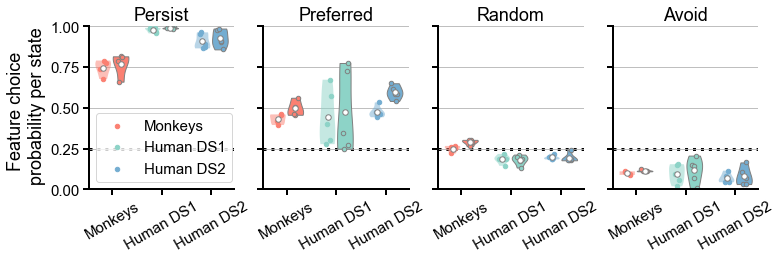

In [3]:
# Collect probabilities
pc_S_mdl = np.zeros([numSubjects,4])
pc_S_emp = np.zeros([numSubjects,4])

for i in range(numSubjects):
    pc_S_mdl[i,:] = analysis[i]['choiceStats']['pc_S_mdl']
    pc_S_emp[i,:] = analysis[i]['choiceStats']['pc_S_emp']

vLoc = [0,2,4]
vpWidth = 0.7

fig, ax = plt.subplots(ncols=4,nrows=1,sharex=True,sharey=True,figsize=(4*3,3))

for k in range(4): # states
    for spInd in range(3): # monkey and 2 human datasets
        for src in range(2): # source of measure (model vs. empirical)
            if src == 0:
                pc = pc_S_mdl
            else:
                pc = pc_S_emp

            # Violin
            data1 = pc[np.where(speciesList == spInd)[0],k]
            x1 = vLoc[spInd]-vpWidth/2 + 2*src*(vpWidth/2)
            vp1 = ax[k].violinplot(data1,[x1],showextrema=False,widths=0.9*vpWidth)
            for pc in vp1['bodies']:
                pc.set_facecolor(speciesColor[spInd])
                if src == 0:
                    pc.set_alpha(0.5)
                else:
                    pc.set_edgecolor('gray')
                    pc.set_alpha(1)

            # Points
            x = npr.rand(np.where(speciesList == spInd)[0].size) * (vpWidth) * (0.2)
            pm = getPM(x.shape[0])
            x = np.multiply(x,pm) + x1
            if src == 0:
                ax[k].scatter(x,data1,s=20,color=speciesColor[spInd], label = speciesNameLeg[spInd])
            else:
                ax[k].scatter(x,data1,s=20,color=speciesColor[spInd], edgecolor='gray')

            ax[k].scatter(x1,np.mean(data1),color='white',s=30,edgecolors='gray')

    #####################
    # Prettify
    
    xlim = ax[k].get_xlim()
    ax[k].hlines(0.25,xmin=xlim[0],xmax=xlim[1],color='black',linestyle='dotted',zorder=0,linewidth=3)
    ax[k].set_xlim(xlim)
    
    ax[k].set_title(stateNames[k],fontsize=18)
    if k == 0:
        ax[k].set_ylabel('Feature choice \n probability per state',fontsize=18)
        ax[k].legend(fontsize=15)
    
    ax[k].set_ylim([0,1])
    ax[k].set_yticks([0,0.25,0.5,0.75,1])
    ax[k].set_xticks(vLoc)
    ax[k].set_xticklabels(speciesNameLeg,fontsize=20, rotation=30)
    
    ax[k].tick_params(axis='both',labelsize=15,direction='out',width=2, length=6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[k].spines[axis].set_linewidth(2)

    ax[k].spines['right'].set_visible(False)
    ax[k].spines['top'].set_visible(False)
    
    ax[k].set_axisbelow(True)
    ax[k].grid(which='major', axis='y')
    
# plt.savefig('figures/fig3/choiceProb.eps', format='eps')

## Intra-dimensional transition relationship

In [9]:
# Collect dat

# transition down
pDown = np.zeros((numSubjects))
for i in range(numSubjects):
    dat=analysis[i]['categoryAnalysis']['infProcsUp']#[0]
    
    dnCnt = 0
    totCnt = 0

    for j in range(dat.shape[0]):            
        if dat[j,0] < 3: # feature was not in avoid
            if dat[j,2] == 1: # feature belongs to the same dimension as the (other) feature that transitioned up
                dnCnt += int(dat[j,0] < dat[j,1]) # feature transitioned down
                totCnt += 1

    if totCnt == 0 and dnCnt ==0:
        pDown[i] = np.nan
    else:
        pDown[i] = dnCnt/totCnt

# transition up
pUp = np.zeros((numSubjects))
for i in range(numSubjects):
    dat=analysis[i]['categoryAnalysis']['infProcsDown']

    upCnt = 0
    totCnt = 0

    for j in range(dat.shape[0]):            

        if dat[j,0] > 0: # feature was not in persist on previous trial
            if dat[j,2] == 1: # feature belongs to the same dimension as the (other) feature that transitioned down
                upCnt += int(dat[j,0] > dat[j,1]) # this feature transitioned up
                totCnt += 1

    if totCnt == 0 and upCnt ==0:
        pUp[i] = np.nan
    else:
        pUp[i] = upCnt/totCnt


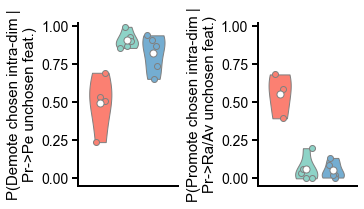

In [16]:
# Plot

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(5,3))

vpWidth = 0.5

for i in np.unique(speciesList): # Species
    idx = np.where(np.array(speciesList) == i)[0]
    for j in range(2): # transition type
        if j == 0:
            dat = pDown[idx]
        else:
            dat = pUp[idx]            
        dat = np.delete(dat, np.nonzero(np.isnan(dat))[0], axis=0)
        
        # Violin
        vp = ax[j].violinplot(dat,[i*0.6],showextrema=False,widths=vpWidth)

        # Points
        x = npr.rand(dat.shape[0]) * (vpWidth) * (0.3)
        pm = getPM(dat.shape[0])
        x = np.multiply(x,pm)+i*0.6#-0.1#i-0.1 #np.multiply(x,pm) + i

        ax[j].scatter(x,dat,color=speciesColor[i],edgecolors='gray')

        for pc in vp['bodies']:
            pc.set_facecolor(speciesColor[i])
            pc.set_edgecolor('gray')
            pc.set_alpha(1)

        ax[j].scatter(i*0.6,np.mean(dat),color='white',s=50,edgecolors='gray')  

# Prettify
for j in range(2): # transition type
    ax[j].set_ylim([-0.05,1.02])
    ax[j].set_xlim([-0.5,1.75])
    ax[j].set_xticks([])

    ax[j].set_yticks([0,0.25,0.5,0.75,1])
    if j == 0:
        ax[j].set_ylabel('P(Demote chosen intra-dim |\nPr->Pe unchosen feat.)', fontsize=15)
    else:
        ax[j].set_ylabel('P(Promote chosen intra-dim |\nPr->Ra/Av unchosen feat.)', fontsize=15)        
        
    ax[j].tick_params(axis='both',labelsize= 14,direction='out',width=2, length=6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[j].spines[axis].set_linewidth(2)

    ax[j].spines['right'].set_visible(False)
    ax[j].spines['top'].set_visible(False)

    plt.subplots_adjust(wspace=0.8, 
                        hspace=0.0)
    
# plt.savefig('figures/fig3/infUpDown.eps', format='eps')

## Change in probability when feature in preferred state and not chosen

In [18]:
# Collect dat
delta_Pc_NC_min = np.zeros((numSubjects))
delta_Pc_NC_plus = np.zeros((numSubjects))

for i in range(numSubjects):
    delta_Pc_NC_min[i] = analysis[i]['choicePreviousStateStats']['pc_HS0_mdl'][0,1]-analysis[i]['choicePreviousStateStats']['pc_S0_mdl'][1]
    delta_Pc_NC_plus[i] = analysis[i]['choicePreviousStateStats']['pc_HS0_mdl'][1,1]-analysis[i]['choicePreviousStateStats']['pc_S0_mdl'][1]



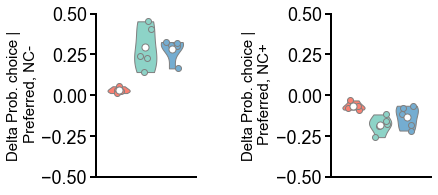

In [28]:
# Plot

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(6,3))

vpWidth = 0.5

for i in np.unique(speciesList): # Species
    idx = np.where(np.array(speciesList) == i)[0]
    for j in range(2): # Delta probability type
        if j == 0:
            dat = delta_Pc_NC_min[idx]
        else:
            dat = delta_Pc_NC_plus[idx]
        dat = np.delete(dat, np.nonzero(np.isnan(dat))[0], axis=0)
        
        # Violin
        vp = ax[j].violinplot(dat,[i*0.6],showextrema=False,widths=vpWidth)

        # Points
        x = npr.rand(dat.shape[0]) * (vpWidth) * (0.3)
        pm = getPM(dat.shape[0])
        x = np.multiply(x,pm)+i*0.6

        ax[j].scatter(x,dat,color=speciesColor[i],edgecolors='gray')

        for pc in vp['bodies']:
            pc.set_facecolor(speciesColor[i])
            pc.set_edgecolor('gray')
            pc.set_alpha(1)

        ax[j].scatter(i*0.6,np.mean(dat),color='white',s=50,edgecolors='gray')  

# Prettify
for j in range(2): # Delta probability type
    ax[j].set_ylim([-0.5,0.5])
    ax[j].set_xlim([-0.5,1.75])
    ax[j].set_xticks([])

    ax[j].set_yticks([-0.5, -0.25, 0,0.25,0.5])
    if j == 0:
        ax[j].set_ylabel('Delta Prob. choice |\n Preferred, NC-',fontsize=15)
    else:
        ax[j].set_ylabel('Delta Prob. choice |\n Preferred, NC+',fontsize=15)

    ax[j].tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[j].spines[axis].set_linewidth(2)

    ax[j].spines['right'].set_visible(False)
    ax[j].spines['top'].set_visible(False)

    plt.subplots_adjust(wspace=1.35, 
                        hspace=0.0)
    
# plt.savefig('figures/fig3/deltInference.eps', format='eps')

## Choice probability conditioned on state and history

In [30]:
#Collect dat 

pc_HS = np.zeros([numSubjects,4,4,2])

for i in range(numSubjects):
    
    pc_HS[i,:,:,0] = analysis[i]['choiceStats']['pc_HS_mdl']
    pc_HS[i,:,:,1] = analysis[i]['choiceStats']['pc_HS_emp']
pc_HS[np.isnan(pc_HS)] = 0


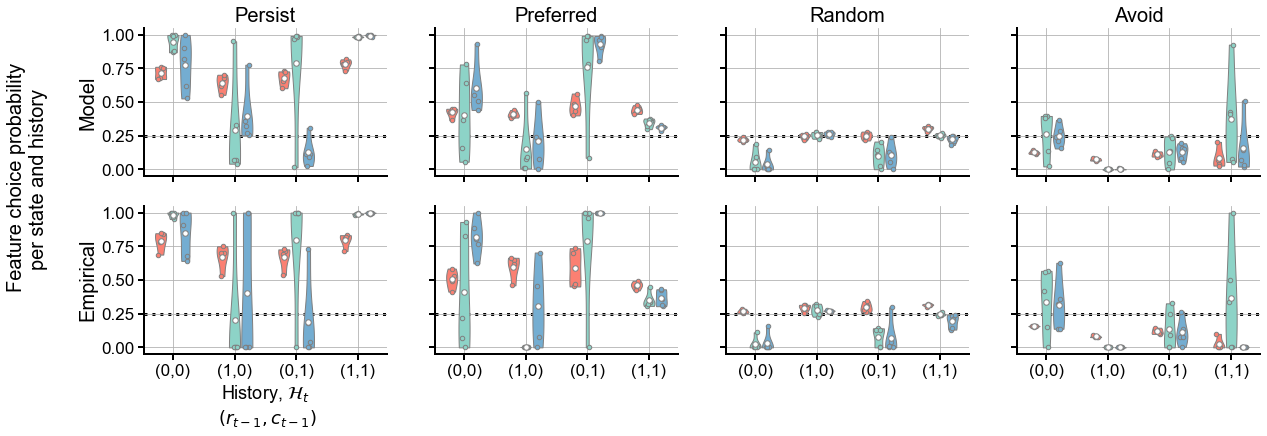

In [38]:
# Plot
historyNames = ['(0,0)','(1,0)','(0,1)','(1,1)']

vLoc = [0,3.75,7.5,11.25]
vpWidth = 0.75

fig, ax = plt.subplots(ncols=4,nrows=2,sharex=True,sharey=True,figsize=(4*5,6))

fig.text(0.03, 0.54, 'Feature choice probability \n    per state and history', va='center', rotation='vertical', size=20)

for  i in range(2): # model, empirical
    for k in range(4): # state
        for h in range(4): # history
            for s in np.unique(speciesList):
                idx = np.where(np.array(speciesList) == s)[0]

                dat1 = pc_HS[idx,h,k,i]
                x1 = vLoc[h]-vpWidth + s*(vpWidth)
                
                # Violins
                vp1 = ax[i,k].violinplot(dat1,[x1],showextrema=False,widths=0.9*vpWidth)
                for pc in vp1['bodies']:
                    pc.set_facecolor(speciesColor[s])#'#fb8072') CHANGE
                    pc.set_edgecolor('gray')
                    pc.set_alpha(1)

                # Points
                x = npr.rand(len(idx)) * (vpWidth) * (0.2)
                pm = getPM(x.shape[0])
                x = np.multiply(x,pm) + x1
                ax[i,k].scatter(x,dat1,s=20,color=speciesColor[s],edgecolors='gray')
                ax[i,k].scatter(x1,np.mean(dat1),color='white',s=30,edgecolors='gray')

        ####################

        # Prettify
        xlim = ax[i,k].get_xlim()
        ax[i,k].hlines(0.25,xmin=xlim[0],xmax=xlim[1],color='black',linestyle='dotted',zorder=0,linewidth=3)
        ax[i,k].set_xlim(xlim)
        
        if i == 0:
            ax[i,k].set_title(stateNames[k],fontsize=20)
        if i == 0 and k == 0:
            ax[i,k].set_ylabel('Model',fontsize=20)
        #if k == 0:
        #    ax[i,k].set_ylabel('$P ( c_t = 1 \mid \mathcal{H}_t, z_t )$',fontsize=20)
        if i == 1 and k == 0:
            ax[i,k].set_xlabel('History, $\mathcal{H}_t$ \n $(r_{t-1},c_{t-1})$',fontsize=18)
            ax[i,k].set_ylabel('Empirical',fontsize=20)

        ax[i,k].set_ylim([-0.05,1.05])
        ax[i,k].set_xticks(vLoc)
        ax[i,k].set_yticks([0,0.25,0.5,0.75,1])
        ax[i,k].set_xticklabels(historyNames)

        ax[i,k].tick_params(axis='both',labelsize= 17,direction='out',width=2, length=6)
        # change all spines
        for axis in ['top','bottom','left','right']:
            ax[i,k].spines[axis].set_linewidth(2)

        ax[i,k].spines['right'].set_visible(False)
        ax[i,k].spines['top'].set_visible(False)

        ax[i,k].set_axisbelow(True)
        ax[i,k].grid(which='major', axis='both')
        
# plt.savefig('figures/fig3/choiceProbability.eps', format='eps')

### Helper function to plot transition probabilities

In [41]:
# Plot transition matrix
def plotTransitionMatrix(pz_HS, ax):
    vLoc = [0,3.75,7.5,11.25]
    vpWidth = 0.75
    fig.text(0.52, 0.92, 'Next state', ha='center', size=20)
    fig.text(0.0, 0.5, 'Current state', va='center', rotation='vertical', size=20)

    for s in range(4): # from state
        for t in range(4): # to state
            for h in range(4): # history
                for sp in np.unique(speciesList): # species
                    idx = np.where(np.array(speciesList) == sp)[0]

                    dat1 = pz_HS[idx,t,h,s]
                    dat1 = np.delete(dat1, np.nonzero(np.isnan(dat1))[0], axis=0)
                    if np.sum(np.isnan(dat1)) > 0:
                        print(dat1)
                        print('prob')
                    if dat1.shape[0] > 0:
                        x1 = vLoc[h]-vpWidth + sp*vpWidth
                        
                        # Violins
                        vp1 = ax[s,t].violinplot(dat1,[x1],showextrema=False,widths=0.9*vpWidth)
                        for pc in vp1['bodies']:
                            pc.set_facecolor(speciesColor[sp])
                            pc.set_edgecolor('gray')
                            pc.set_alpha(1)

                        # Points
                        x = npr.rand(dat1.shape[0]) * (vpWidth) * (0.2)
                        pm = getPM(x.shape[0])
                        x = np.multiply(x,pm) + x1
                        ax[s,t].scatter(x,dat1,s=20,color=speciesColor[sp],edgecolors='gray')

                        ax[s,t].scatter(x1,np.mean(dat1),color='white',s=30,edgecolors='gray')

            ####################
            
            # Prettify

            xlim = ax[s,t].get_xlim()
            ax[s,t].set_xlim(xlim)

            if t == 0:
                ax[s,t].text(-8.5,0.25,stateNames[s],fontsize=16,rotation='vertical')


            if s == 0:
                ax[s,t].set_title(stateNames[t],fontsize=16)

            if s == 3 and t == 0:
                ax[s,t].set_ylabel('Transition probability given \n history and current state',fontsize=16)
                ax[s,t].set_xlabel('$\mathcal{H}_t$, $(r_{t-1},c_{t-1})$',fontsize=16)

            ax[s,t].set_ylim([-0.05,1.05])
            ax[s,t].set_xticks(vLoc)
            ax[s,t].set_yticks([0,0.25,0.5,0.75,1])
            ax[s,t].set_xticklabels(historyNames)
            ax[s,t].tick_params(axis='both',labelsize= 15,direction='out',width=2, length=6)
            # change all spines
            for axis in ['top','bottom','left','right']:
                ax[s,t].spines[axis].set_linewidth(2)

            ax[s,t].spines['right'].set_visible(False)
            ax[s,t].spines['top'].set_visible(False)

            ax[s,t].grid(which='major', axis='both')
            ax[s,t].set_axisbelow(True)


## Transition probabilities (directly from model)

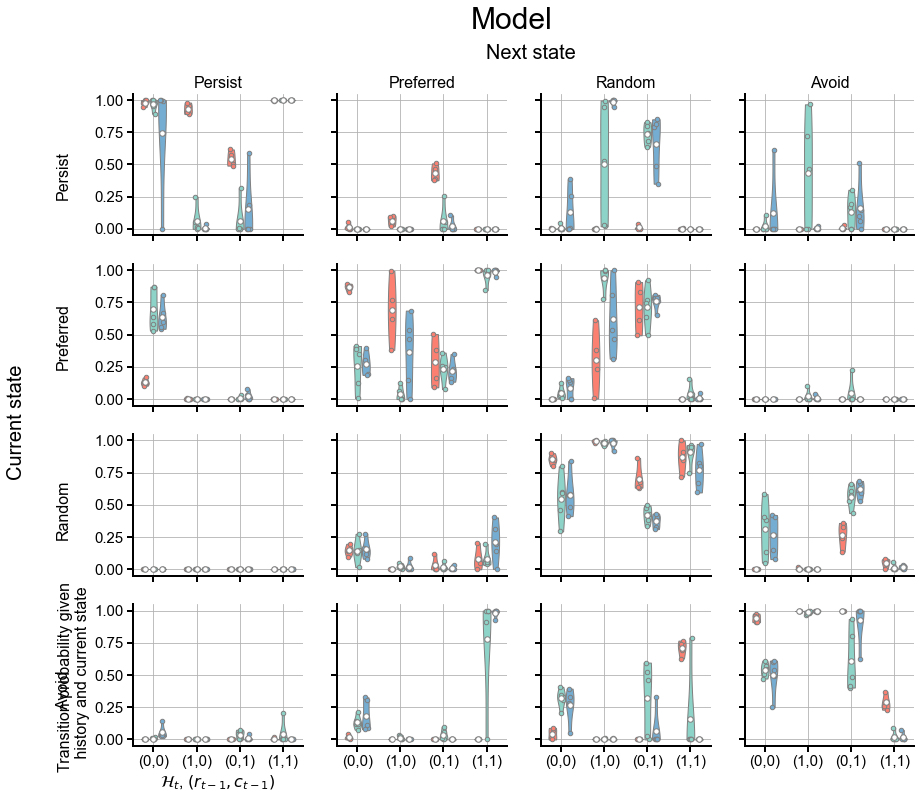

In [47]:
# Collect data
pz_HS_mdl = np.zeros([numSubjects,4,4,4])
for i in range(numSubjects):
    pz_HS_mdl[i] = analysis[i]['transitionStats']['pz_HS_mdl']

# plot
fig, ax = plt.subplots(ncols=4,nrows=4,sharex=True,sharey=True,figsize=(3.5*4,4*3))

fig.suptitle('Model',size=30,y=0.98)
plotTransitionMatrix(pz_HS_mdl, ax)

# plt.savefig('figures/fig3/transProbMdl.eps', format='eps')

## Transition probabilities (empirically from data and most-likely states)

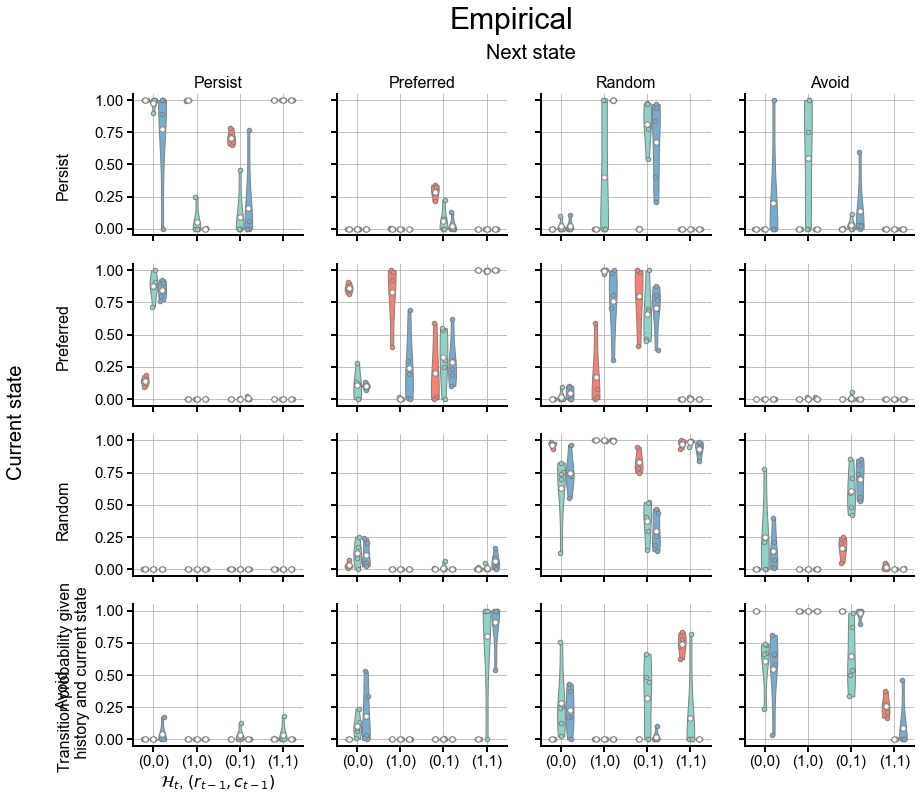

In [46]:
# Collect data
pz_HS_emp = np.zeros([numSubjects,4,4,4])
for i in range(numSubjects):
    pz_HS_emp[i] = analysis[i]['transitionStats']['pz_HS_emp']

# Plot
fig, ax = plt.subplots(ncols=4,nrows=4,sharex=True,sharey=True,figsize=(3.5*4,4*3))

fig.suptitle('Empirical',size=30,y=0.98)

plotTransitionMatrix(pz_HS_emp, ax)

# plt.savefig('figures/fig3/transProbExp.eps', format='eps')

## Reverse transition probabilities (conditioned on target state, computed empirically)

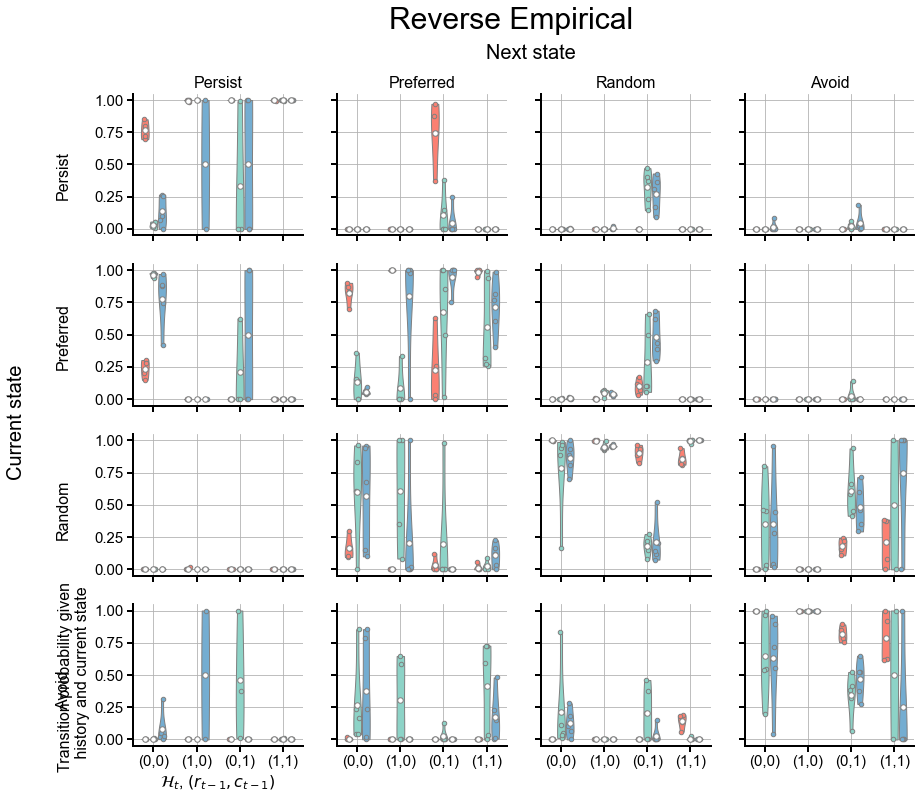

In [45]:
# Collect data
pS_Hz_emp = np.zeros([numSubjects,4,4,4])
for i in range(numSubjects):
    pS_Hz_emp[i] = analysis[i]['transitionStats']['pS_Hz_emp'][0]

# Plot
fig, ax = plt.subplots(ncols=4,nrows=4,sharex=True,sharey=True,figsize=(3.5*4,4*3))

fig.suptitle('Reverse Empirical',size=30,y=0.98)
plotTransitionMatrix(pS_Hz_emp, ax)

# plt.savefig('figures/fig3/revTransProbExp.eps', format='eps')

## Probability of exploring a feature while avoiding intra-dimensional features

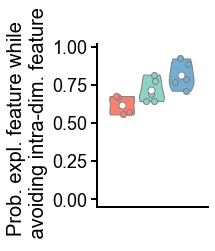

In [60]:
# Collect data
pExp_avoidIntraDim = np.zeros((numSubjects))
for i in range(numSubjects):
    pExp_avoidIntraDim[i] = analysis[i]['categoryAnalysis']['avoidAdjacent']

# Plot
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(2,3))

vpWidth = 0.5

for i in np.unique(speciesList): # Species
    idx = np.where(np.array(speciesList) == i)[0]
    dat = pExp_avoidIntraDim[idx]
    
    # Violins
    vp = ax.violinplot(dat,[i*0.6],showextrema=False,widths=vpWidth)

    for pc in vp['bodies']:
        pc.set_facecolor(speciesColor[i])
        pc.set_edgecolor('gray')
        pc.set_alpha(1)
    
    # Points
    x = npr.rand(dat.shape[0]) * (vpWidth) * (0.3)
    pm = getPM(dat.shape[0])
    x = np.multiply(x,pm)+i*0.6

    ax.scatter(x,dat,color=speciesColor[i],edgecolors='gray')
    ax.scatter(i*0.6,np.mean(dat),color='white',s=50,edgecolors='gray')  

# Prettify
ax.set_ylim([-0.05,1.02])
ax.set_xlim([-0.5,1.75])
ax.set_xticks([])

ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_ylabel('Prob. expl. feature while \n avoiding intra-dim. feature',fontsize=20)

ax.tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('figures/fig3/combRandAv.eps', format='eps')

## Probability of history under each state

In [61]:
# Collect Data
pH_S = np.zeros([numSubjects,4,4])

for i in range(numSubjects):
    pH_S[i,:,:] = analysis[i]['choiceStats']['pH_S']

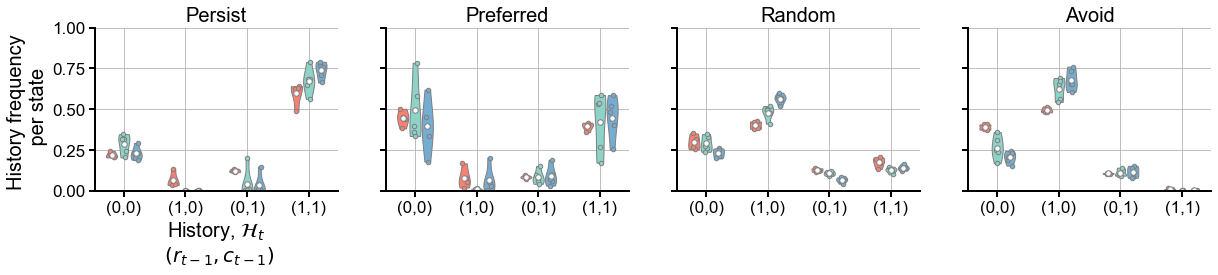

In [63]:
# Plot
vLoc = [0,3.75,7.5,11.25]
vpWidth = 0.75

fig, ax = plt.subplots(ncols=4,nrows=1,sharex=True,sharey=True,figsize=(4*5,3))

for k in range(4): # state
    for h in range(4): # history
        for s in np.unique(speciesList): # Species
            idx = np.where(np.array(speciesList) == s)[0]

            dat1 = pH_S[idx,h,k]
            x1 = vLoc[h]-vpWidth + s*vpWidth
            
            # Violins
            vp1 = ax[k].violinplot(dat1,[x1],showextrema=False,widths=0.9*vpWidth)
            for pc in vp1['bodies']:
                pc.set_facecolor(speciesColor[s])
                pc.set_edgecolor('gray')
                pc.set_alpha(1)

            # Points
            x = npr.rand(len(idx)) * (vpWidth) * (0.2)
            pm = getPM(x.shape[0])
            x = np.multiply(x,pm) + x1
            ax[k].scatter(x,dat1,s=20,color=speciesColor[s],edgecolors='gray')

            ax[k].scatter(x1,np.mean(dat1),color='white',s=30,edgecolors='gray')

    ####################

    # Prettify
    
    xlim = ax[k].get_xlim()
    ax[k].set_xlim(xlim)
    
    ax[k].set_title(stateNames[k],fontsize=20)
    if k == 0:
        ax[k].set_ylabel('History frequency \n per state', fontsize=20)
        ax[k].set_xlabel('History, $\mathcal{H}_t$ \n $(r_{t-1},c_{t-1})$',fontsize=20)
    
    ax[k].set_ylim([0,1])
    ax[k].set_xticks(vLoc)
    ax[k].set_yticks([0,0.25,0.5,0.75,1])
    ax[k].set_xticklabels(historyNames)
    
    ax[k].tick_params(axis='both',labelsize= 17,direction='out',width=2, length = 6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[k].spines[axis].set_linewidth(2)

    ax[k].spines['right'].set_visible(False)
    ax[k].spines['top'].set_visible(False)
    
    ax[k].set_axisbelow(True)
    ax[k].grid(which='major', axis='both')
    
# plt.savefig('figures/fig3/histFreq.eps', format='eps')

In [ ]:
# Strategy deviation of humans (dataset2 compared to dataset1)
# Indirect:
#   Persist
#       NC+ - Random/Avoid
#       NC- - Persist
#   Preferred
#       NC+ - Mostly Random/Avoid, little preferred

